In [79]:
import planetary_computer
from pystac_client import Client
import stackstac
import odc.stac
import geopandas
import numpy
import rich.table
import rasterio
import xarray

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import Image


In [3]:
# A simple layer to provide context when plotting
countries_gdf = geopandas.read_file("../country.geojson")

In [4]:
catalog = Client.open("https://planetarycomputer.microsoft.com/api/stac/v1")

In [5]:
time_range = "2018-01-01/2020-12-31"
bbox = [100.35, 4.35, 100.85, 5.1]

search = catalog.search(collections=["landsat-8-c2-l2"], bbox=bbox, datetime=time_range)
items = search.get_all_items()

In [6]:
len(items)

205

## Iterate through scenes to find scene for the row/path of interest with the lowest cloud cover.

In [7]:
roi_row = "057"
roi_path = "128"

found_sel_item = False
sel_item_cloud = 100

for item in items:
    if (item.properties["landsat:wrs_row"] == roi_row) and (item.properties["landsat:wrs_path"] == roi_path):
        if found_sel_item:
            if item.properties["eo:cloud_cover"] < sel_item_cloud:
                sel_item = item
                sel_item_cloud = item.properties["eo:cloud_cover"]
        else:
            sel_item = item
            found_sel_item = True
            sel_item_cloud = item.properties["eo:cloud_cover"]

print(sel_item.id)
    

LC08_L2SP_128057_20180630_02_T1


## Display quicklook image so we know what to expect

In [8]:
sel_item.assets["rendered_preview"].to_dict()

{'href': 'https://planetarycomputer.microsoft.com/api/data/v1/item/preview.png?collection=landsat-8-c2-l2&item=LC08_L2SP_128057_20180630_02_T1&assets=SR_B4&assets=SR_B3&assets=SR_B2&color_formula=gamma+RGB+2.7%2C+saturation+1.5%2C+sigmoidal+RGB+15+0.55',
 'type': 'image/png',
 'title': 'Rendered preview',
 'rel': 'preview',
 'roles': ['overview']}

In [9]:
Image(url=sel_item.assets["rendered_preview"].href, width=500)

## Sign the item so we can get urls to do work...

In [10]:
sel_item_signed = planetary_computer.sign(sel_item)


## Functions taken from RSGISLib for stretching image data for visualisation

In [11]:
def limit_range_np_arr(
    arr_data: numpy.array,
    min_thres: float = 0,
    min_out_val: float = 0,
    max_thres: float = 1,
    max_out_val: float = 1,
) -> numpy.array:
    """
    A function which can be used to limit the range of the numpy array.
    For example, to mask values less than 0 to 0 and values greater than
    1 to 1.

    :param arr_data: input numpy array.
    :param min_thres: the threshold for the minimum value.
    :param min_out_val: the value assigned to values below the min_thres
    :param max_thres: the threshold for the maximum value.
    :param max_out_val: the value assigned to the values above the max_thres
    :return: numpy array with output values.

    """
    arr_data_out = arr_data.copy()
    arr_data_out[arr_data < min_thres] = min_out_val
    arr_data_out[arr_data > max_thres] = max_out_val
    return arr_data_out


def cumulative_stretch_np_arr(
    arr_data: numpy.array,
    no_data_val: float = None,
    lower: int = 2,
    upper: int = 98,
    out_off: float = 0,
    out_gain: float = 1,
    out_int_type=False,
    min_out_val: float = 0,
    max_out_val: float = 1,
) -> numpy.array:
    """
    A function which performs a cumulative stretch using an upper and lower
    percentile to define the min-max values. This analysis is on a per
    band basis for a numpy array representing an image dataset. This function
    is useful in combination with get_gdal_raster_mpl_imshow for displaying
    raster data from an input image as a plot. By default this function returns
    values in a range 0 - 1 but if you prefer 0 - 255 then set the out_gain to
    255 and the out_int_type to be True to get an 8bit unsigned integer value.

    :param arr_data: The numpy array as either [n,m,b] or [n,m] where n and m are
                     the number of image pixels in the x and y axis' and b is the
                     number of image bands.
    :param no_data_val: the no data value for the input data. If there isn't a no
                        data value then leave as None (default)
    :param lower: lower percentile (default: 2)
    :param upper: upper percentile (default: 98)
    :param out_off: Output offset value (value * gain) + offset. Default: 0
    :param out_gain: Output gain value (value * gain) + offset. Default: 1
    :param out_int_type: False (default) and the output type will be float and
                         True and the output type with be integers.
    :param min_out_val: Minimum output value within the output array (default: 0)
    :param max_out_val: Maximum output value within the output array (default: 1)
    :return: A number array with the rescaled values but same dimensions as the
             input numpy array.

    .. code:: python

        img_sub_bbox = [554756, 577168, 9903924, 9944315]
        input_img = "sen2_img_strch.kea"

        img_data_arr, coords_bbox = get_gdal_raster_mpl_imshow(input_img,
                                                               bands=[8,9,3],
                                                               bbox=img_sub_bbox)

        img_data_arr = cumulative_stretch_np_arr(img_data_arr, no_data_val=0.0)

        import matplotlib.pyplot as plt
        fig, ax = plt.subplots()
        im = ax.imshow(img_data_arr, extent=coords_bbox)
        plt.show()

    """
    arr_shp = arr_data.shape

    if no_data_val is not None:
        arr_data_out = arr_data.astype(float)
        arr_data_out[arr_data == no_data_val] = numpy.nan
    else:
        arr_data_out = arr_data.copy()

    if len(arr_shp) == 2:
        min_val, max_val = numpy.nanpercentile(arr_data_out, [lower, upper])
        range_val = max_val - min_val

        arr_data_out = (((arr_data_out - min_val) / range_val) * out_gain) + out_off
    else:
        n_bands = arr_shp[2]
        for n in range(n_bands):
            min_val, max_val = numpy.nanpercentile(arr_data_out[..., n], [lower, upper])
            range_val = max_val - min_val

            arr_data_out[..., n] = (
                ((arr_data_out[..., n] - min_val) / range_val) * out_gain
            ) + out_off

    arr_data_out = limit_range_np_arr(
        arr_data_out,
        min_thres=min_out_val,
        min_out_val=min_out_val,
        max_thres=max_out_val,
        max_out_val=max_out_val,
    )

    if out_int_type:
        arr_data_out = arr_data_out.astype(int)

    return arr_data_out

# Read the data into an xarray

Just reading the single item so add to list - note the item is already signed.

In [12]:
bands = ["SR_B1", "SR_B2", "SR_B3", "SR_B4", "SR_B5", "SR_B6", "SR_B7"]
ls8_scn_xa = odc.stac.load([sel_item_signed], bands=bands)

In [13]:
ls8_scn_xa

<xarray.Dataset>
Dimensions:      (time: 1, y: 7732, x: 7572)
Coordinates:
  * time         (time) datetime64[ns] 2018-06-30T03:33:25.534703
  * y            (y) float64 5.952e+05 5.952e+05 ... 3.633e+05 3.633e+05
  * x            (x) float64 5.118e+05 5.118e+05 ... 7.389e+05 7.389e+05
    spatial_ref  int32 32647
Data variables:
    SR_B1        (time, y, x) uint16 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
    SR_B2        (time, y, x) uint16 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
    SR_B3        (time, y, x) uint16 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
    SR_B4        (time, y, x) uint16 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
    SR_B5        (time, y, x) uint16 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
    SR_B6        (time, y, x) uint16 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
    SR_B7        (time, y, x) uint16 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
Attributes:
    crs:           EPSG:32647
    grid_mapping:  spatial_ref

## Visualise the image data

Not sure if this is really the best way to do it but it works...

In [14]:
band_stack = numpy.vstack([ls8_scn_xa["SR_B5"].values, ls8_scn_xa["SR_B6"].values, ls8_scn_xa["SR_B4"].values])
band_stack.shape
band_stack = numpy.moveaxis(band_stack, 0, -1)
band_stack_stch = cumulative_stretch_np_arr(band_stack, no_data_val=0.0)

In [15]:
img_bbox = [float(ls8_scn_xa.x.min()), float(ls8_scn_xa.x.max()), float(ls8_scn_xa.y.min()), float(ls8_scn_xa.y.max())]
img_bbox

[511785.0, 738915.0, 363285.0, 595215.0]

(485000.0, 550000.0)

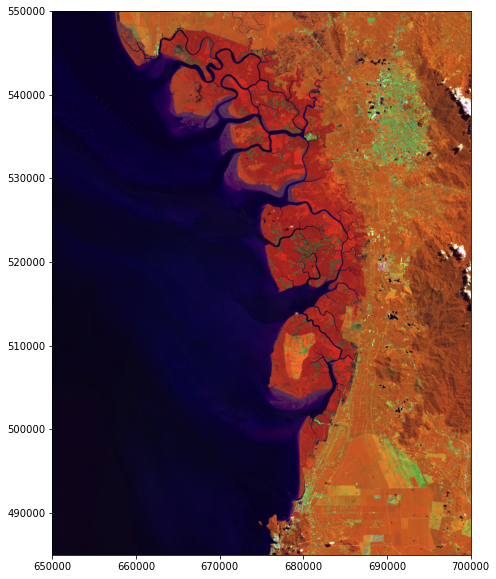

In [16]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(band_stack_stch, extent=img_bbox)
ax.set_xlim([650000, 700000])
ax.set_ylim([485000, 550000])

## Define to ROI for Classification from GMW Extent

In [17]:
from shapely.geometry import Polygon

In [18]:
x_point_list = [img_bbox[0], img_bbox[1], img_bbox[1], img_bbox[0]]
y_point_list = [img_bbox[3], img_bbox[3], img_bbox[2], img_bbox[2]]

img_bbox_geom = Polygon(zip(x_point_list, y_point_list))
crs = {'init': ls8_scn_xa.crs}
img_bbox_gdf = geopandas.GeoDataFrame(index=[0], crs=crs, geometry=[img_bbox_geom])
img_bbox_wgs84_gdf = img_bbox_gdf.to_crs("EPSG:4326")

img_bbox_wgs84_buf_gdf = img_bbox_wgs84_gdf.buffer(1)

/srv/conda/envs/notebook/lib/python3.8/site-packages/pyproj/crs/crs.py:130: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/tmp/ipykernel_1625/1866214467.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  img_bbox_wgs84_buf_gdf = img_bbox_wgs84_gdf.buffer(1)


In [19]:
img_bbox_wgs84_buf_gdf.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [20]:
#[511785.0, 738915.0, 363285.0, 595215.0]
img_bbox_gdf.bounds

,minx,miny,maxx,maxy
0,511785.0,363285.0,738915.0,595215.0


In [21]:
img_bbox_wgs84_gdf.bounds

,minx,miny,maxx,maxy
0,99.106082,3.284393,101.156006,5.384929


(1.0, 7.0)

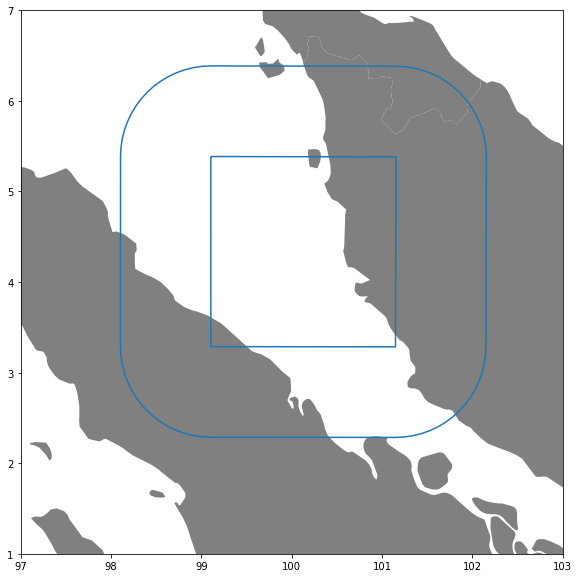

In [22]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
countries_gdf.plot(ax=ax, color='grey')
img_bbox_wgs84_gdf.boundary.plot(ax=ax)
img_bbox_wgs84_buf_gdf.boundary.plot(ax=ax)

ax.set_xlim([97, 103])
ax.set_ylim([1, 7])


## Read the GMW layer into geopandas dataframe

The GMW v2.5 baseline can be downloaded from here: https://zenodo.org/record/5828339#.YrLLqOzMJCU

In [23]:
# Would only be run once and you might need to change path in geopandas call below.
#!wget https://zenodo.org/record/5828339/files/gmw_2010_v25_vecs.gpkg.gz?download=1

In [24]:
gmw_gdf = geopandas.read_file("../../globalmangrovewatch/gmw_2010_v25_vecs.gpkg", layer="gmw_2010_v25")


### Subset to the ROI

In [25]:
gmw_sub_gdf = geopandas.clip(gmw_gdf, img_bbox_wgs84_buf_gdf)

(1.0, 7.0)

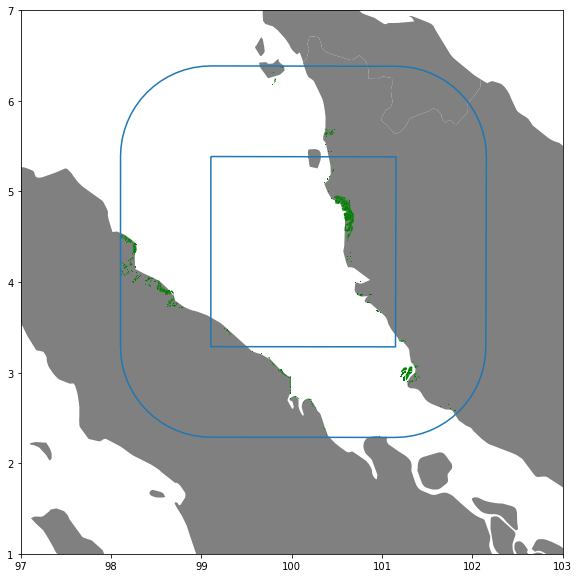

In [26]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
countries_gdf.plot(ax=ax, color='grey')
img_bbox_wgs84_gdf.boundary.plot(ax=ax)
img_bbox_wgs84_buf_gdf.boundary.plot(ax=ax)
gmw_sub_gdf.plot(ax=ax, color="green")

ax.set_xlim([97, 103])
ax.set_ylim([1, 7])

### Reproject to image CRS

In [29]:
gmw_sub_imgcrs_gdf = gmw_sub_gdf.to_crs(ls8_scn_xa.crs)

(485000.0, 550000.0)

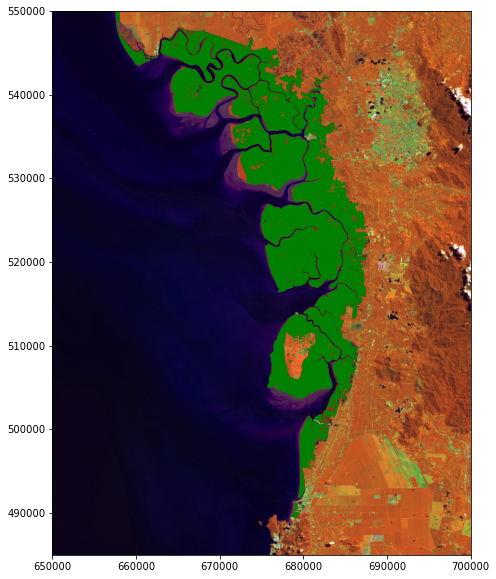

In [28]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(band_stack_stch, extent=img_bbox)
gmw_sub_imgcrs_gdf.plot(ax=ax, color="green")
ax.set_xlim([650000, 700000])
ax.set_ylim([485000, 550000])

## Create Mangrove ROI

 1. Buffer mangroves by 2km

In [30]:
gmw_sub_imgcrs_buf2000_srs = gmw_sub_imgcrs_gdf.buffer(2000)
gmw_sub_imgcrs_buf2000_gdf = gmw_sub_imgcrs_gdf.set_geometry(gmw_sub_imgcrs_buf2000_srs)

(485000.0, 550000.0)

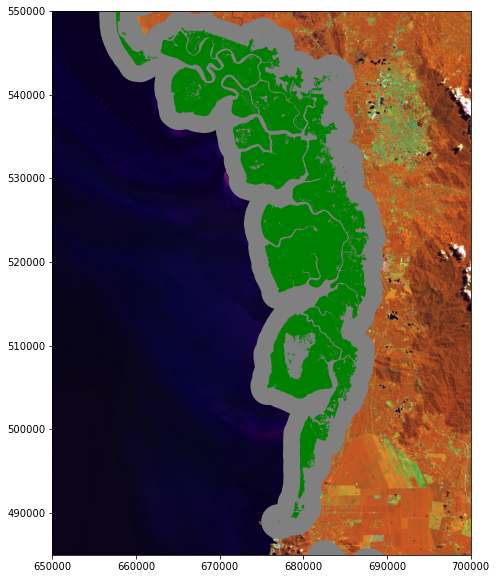

In [31]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(band_stack_stch, extent=img_bbox)

gmw_sub_imgcrs_buf2000_gdf.plot(ax=ax, color="grey")

gmw_sub_imgcrs_gdf.plot(ax=ax, color="green")

ax.set_xlim([650000, 700000])
ax.set_ylim([485000, 550000])

## Rasterise the Mangrove ROI for classification

In [33]:
import geocube
from geocube.api.core import make_geocube

In [37]:
# Rasterise the 1km buffer
gmw_buf2000_xa = make_geocube(gmw_sub_imgcrs_buf2000_gdf, like=ls8_scn_xa)

In [38]:
gmw_buf2000_xa = gmw_buf2000_xa.rename({"PXLVAL": "cls_roi"})
gmw_buf2000_xa = gmw_buf2000_xa.fillna(0).astype(numpy.uint8)
gmw_buf2000_xa

<xarray.Dataset>
Dimensions:      (y: 7732, x: 7572)
Coordinates:
  * y            (y) float64 5.952e+05 5.952e+05 ... 3.633e+05 3.633e+05
  * x            (x) float64 5.118e+05 5.118e+05 ... 7.389e+05 7.389e+05
    spatial_ref  int64 0
Data variables:
    cls_roi      (y, x) uint8 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0

## Add Classification ROI to Landsat xarray

In [39]:
ls8_scn_xa['cls_roi'] = gmw_buf2000_xa["cls_roi"]

In [40]:
ls8_scn_xa

<xarray.Dataset>
Dimensions:      (time: 1, y: 7732, x: 7572)
Coordinates:
  * time         (time) datetime64[ns] 2018-06-30T03:33:25.534703
  * y            (y) float64 5.952e+05 5.952e+05 ... 3.633e+05 3.633e+05
  * x            (x) float64 5.118e+05 5.118e+05 ... 7.389e+05 7.389e+05
    spatial_ref  int32 32647
Data variables:
    SR_B1        (time, y, x) uint16 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
    SR_B2        (time, y, x) uint16 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
    SR_B3        (time, y, x) uint16 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
    SR_B4        (time, y, x) uint16 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
    SR_B5        (time, y, x) uint16 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
    SR_B6        (time, y, x) uint16 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
    SR_B7        (time, y, x) uint16 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
    cls_roi      (y, x) uint8 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0
Attributes:
    crs:           EPSG:32647
    grid_mapping:  spatial_ref

## Read in Reference Data

In [41]:
import h5py

In [42]:
class ClassSimpleInfoObj(object):
    """
    This is a class to store the information associated within the classification.

    :param id: Output pixel value for this class
    :param file_h5: hdf5 file (from rsgislib.zonalstats.extract_zone_img_band_values_to_hdf) with the training
                   data for the class
    :param red: Red colour for visualisation (0-255)
    :param green: Green colour for visualisation (0-255)
    :param blue: Blue colour for visualisation (0-255)

    """

    def __init__(self, id=None, file_h5=None, red=None, green=None, blue=None):
        """

        :param id: Output pixel value for this class
        :param file_h5: hdf5 file (from rsgislib.zonalstats.extract_zone_img_band_values_to_hdf) with the training
               data for the class
        :param red: Red colour for visualisation (0-255)
        :param green: Green colour for visualisation (0-255)
        :param blue: Blue colour for visualisation (0-255)

        """
        self.id = id
        self.file_h5 = file_h5
        self.red = red
        self.green = green
        self.blue = blue

    def __str__(self):
        return "{}: {}, ({}, {}, {})".format(
            self.id, self.file_h5, self.red, self.green, self.blue
        )

    def __repr__(self):
        return "{}: {}, ({}, {}, {})".format(
            self.id, self.file_h5, self.red, self.green, self.blue
        )

In [44]:
cls_train_info = dict()
cls_train_info['Mangroves'] = ClassSimpleInfoObj(id=1, file_h5='mng_ref_smpls.h5', red=0, green=255, blue=0)
cls_train_info['Other'] = ClassSimpleInfoObj(id=2, file_h5='nmng_ref_smpls.h5', red=100, green=100, blue=100)


In [45]:
first = True
num_vars = 0
num_vals = 0
for class_info_val in cls_train_info.values():
    data_shp = h5py.File(class_info_val.file_h5, "r")["DATA/DATA"].shape
    if first:
        num_vars = data_shp[1]
        first = False
    num_vals += data_shp[0]

In [47]:
print("{} x {}".format(num_vars, num_vals))

7 x 100000


In [48]:
ref_data_arr = numpy.zeros([num_vals, num_vars], dtype=float)
ref_class_arr = numpy.zeros([num_vals], dtype=int)

In [50]:
row_init = 0
for key in cls_train_info:
    # Open the dataset
    f = h5py.File(cls_train_info[key].file_h5, "r")
    num_rows = f["DATA/DATA"].shape[0]
    # Copy data and populate classid array
    ref_data_arr[row_init : (row_init + num_rows)] = f["DATA/DATA"]
    ref_class_arr[row_init : (row_init + num_rows)] = cls_train_info[key].id
    row_init += num_rows
    f.close()

# Train Classifier

In [52]:
# Import scikit-learn functions
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

In [53]:
x_train, x_test, y_train, y_test = train_test_split(ref_data_arr, ref_class_arr, train_size=0.8, shuffle=True)

In [54]:
rf_class = RandomForestClassifier(n_jobs=4).fit(x_train, y_train)

In [55]:
rf_class.score(x_train, y_train)

1.0

In [56]:
rf_class.score(x_test, y_test)

0.9753

# Apply Classifier

In [58]:
ls8_scn_df = ls8_scn_xa.to_dataframe().reset_index()

In [59]:
ls8_scn_df

,time,y,x,spatial_ref,SR_B1,SR_B2,SR_B3,SR_B4,SR_B5,SR_B6,SR_B7,cls_roi
0,2018-06-30 03:33:25.534703,595215.0,511785.0,32647,0,0,0,0,0,0,0,0
1,2018-06-30 03:33:25.534703,595215.0,511815.0,32647,0,0,0,0,0,0,0,0
2,2018-06-30 03:33:25.534703,595215.0,511845.0,32647,0,0,0,0,0,0,0,0
3,2018-06-30 03:33:25.534703,595215.0,511875.0,32647,0,0,0,0,0,0,0,0
4,2018-06-30 03:33:25.534703,595215.0,511905.0,32647,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
58546699,2018-06-30 03:33:25.534703,363285.0,738795.0,32647,0,0,0,0,0,0,0,0
58546700,2018-06-30 03:33:25.534703,363285.0,738825.0,32647,0,0,0,0,0,0,0,0
58546701,2018-06-30 03:33:25.534703,363285.0,738855.0,32647,0,0,0,0,0,0,0,0
58546702,2018-06-30 03:33:25.534703,363285.0,738885.0,32647,0,0,0,0,0,0,0,0


## Remove rows which are not within cls_roi or without valid pixel values

In [60]:
ls8_scn_vld_df = ls8_scn_df.drop(ls8_scn_df[ls8_scn_df["cls_roi"]==0].index)

In [61]:
ls8_scn_vld_df.drop(ls8_scn_vld_df[(ls8_scn_df["SR_B1"]==0) & 
                                   (ls8_scn_df["SR_B2"]==0) & 
                                   (ls8_scn_df["SR_B3"]==0) & 
                                   (ls8_scn_df["SR_B4"]==0) & 
                                   (ls8_scn_df["SR_B5"]==0) &
                                   (ls8_scn_df["SR_B6"]==0) & 
                                   (ls8_scn_df["SR_B7"]==0) ].index, inplace=True)

/tmp/ipykernel_1625/3161210481.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ls8_scn_vld_df.drop(ls8_scn_vld_df[(ls8_scn_df["SR_B1"]==0) &


In [62]:
ls8_scn_vld_df

,time,y,x,spatial_ref,SR_B1,SR_B2,SR_B3,SR_B4,SR_B5,SR_B6,SR_B7,cls_roi
5509628,2018-06-30 03:33:25.534703,573405.0,655305.0,32647,7578,8149,9731,8907,7269,7326,7366,1
5509629,2018-06-30 03:33:25.534703,573405.0,655335.0,32647,7596,8170,9739,8918,7313,7369,7399,1
5509630,2018-06-30 03:33:25.534703,573405.0,655365.0,32647,7727,8367,9945,9201,7324,7369,7398,1
5509631,2018-06-30 03:33:25.534703,573405.0,655395.0,32647,7731,8396,10029,9302,7277,7329,7366,1
5509632,2018-06-30 03:33:25.534703,573405.0,655425.0,32647,7677,8369,10035,9352,7319,7369,7391,1
...,...,...,...,...,...,...,...,...,...,...,...,...
45476329,2018-06-30 03:33:25.534703,415065.0,705855.0,32647,9288,10206,11459,11524,11283,7829,7700,1
45476330,2018-06-30 03:33:25.534703,415065.0,705885.0,32647,9263,10199,11436,11521,11306,7805,7680,1
45476331,2018-06-30 03:33:25.534703,415065.0,705915.0,32647,9230,10172,11416,11513,11292,7805,7661,1
45476332,2018-06-30 03:33:25.534703,415065.0,705945.0,32647,9245,10164,11408,11490,11199,7801,7661,1


In [72]:
y_pred = rf_class.predict(ls8_scn_vld_df[["SR_B1", "SR_B2", "SR_B3", "SR_B4", "SR_B5", "SR_B6", "SR_B7"]])

/srv/conda/envs/notebook/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


In [75]:
ls8_scn_vld_df["predicted"] = y_pred

In [76]:
ls8_scn_df["predicted"] = ls8_scn_vld_df["predicted"]

In [83]:
ls8_scn_pred_xa = xarray.Dataset.from_dataframe(ls8_scn_df.set_index(['y', 'x']))

(485000.0, 550000.0)

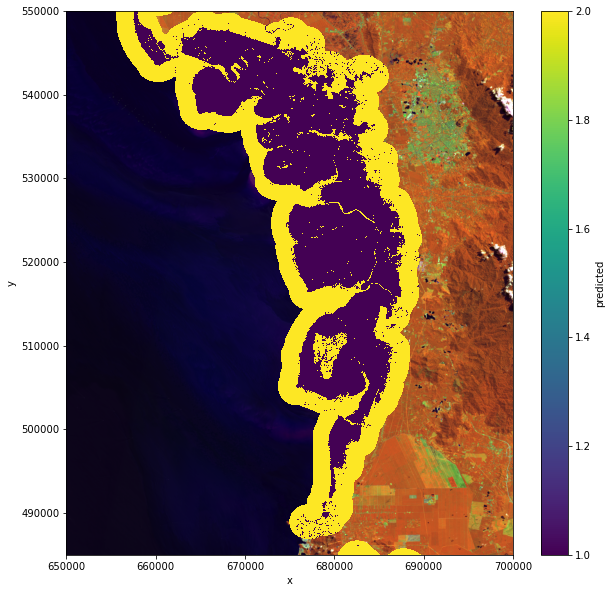

In [86]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(band_stack_stch, extent=img_bbox)

ls8_scn_pred_xa.predicted.plot.imshow(ax=ax)

ax.set_xlim([650000, 700000])
ax.set_ylim([485000, 550000])

# Save Classification to GTIFF

In [87]:
import rioxarray

In [89]:
ls8_scn_pred_xa.predicted.rio.to_raster("mng_cls.tif")